In [1]:
%cd ..

import torch
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
from qcml.bench.grid_search import GridSearch
from qcml.utils.log import log_setup
import os

from src.nn.ansatz.no_entanglement_circuit import no_entanglement_random_circuit
from src.nn.ansatz.full_entanglement_circuit import full_entanglement_circuit
from src.nn.measurements.default import default_measurement
from src.nn.ansatz.NQ_circuit import NQ_circuit
from src.nn.ansatz.ring_circuit import ring_circuit
from src.nn.encodings.IQP_embedding import custom_iqp_embedding
from src.nn.encodings.NQE_embedding import NQE_embedding
from src.nn.encodings.ring_embedding import ring_embedding
from src.nn.encodings.waterfall_embedding import waterfall_embedding
from src.nn.encodings.pennylane_templates import amplitude_embedding, angle_embedding, QAOA_embedding
from src.utils.dataset import EuroSAT
from src.nn.models.hybrid.HQNN_quanv import FlexHybridCNN
from src.utils.training import Trainer

import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

C:\Users\jesus.lozano\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\Users\jesus.lozano\Desktop\Demostrador1\Paper\Repositorio\QML-Satellite-Image-Classification-main


DEBUG:jax._src.path:etils.epath was not found. Using pathlib for file I/O.
DEBUG:git.cmd:Popen(['git', 'version'], cwd=c:\Users\jesus.lozano\Desktop\Demostrador1\Paper\Repositorio\QML-Satellite-Image-Classification-main, stdin=None, shell=False, universal_newlines=False)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=c:\Users\jesus.lozano\Desktop\Demostrador1\Paper\Repositorio\QML-Satellite-Image-Classification-main, stdin=None, shell=False, universal_newlines=False)
DEBUG:wandb.docker.auth:Trying paths: ['C:\\Users\\jesus.lozano\\.docker\\config.json', 'C:\\Users\\jesus.lozano\\.dockercfg']
DEBUG:wandb.docker.auth:No config file found


In [2]:
limit = 100

config = {
    #'allowed_classes': ['Annual\nCrop', 'Forest', 'Herbaceous\nVegetation', 'Industrial', 'Pasture', 'Permanent\nCrop', 'Residential', 'River', 'SeaLake']
    #'allowed_classes': ['HerbaceousVegetation', 'Highway', 'Pasture', 'River', 'SeaLake']
    #'allowed_classes': ['Highway', 'River', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop']
    'allowed_classes': ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', None)
n_classes = 10 if allowed_classes is None else len(allowed_classes)


output = 'dl'
dataset = EuroSAT(root= 'EuroSAT_RGB',
                        num_classes=n_classes,
                        image_size=8,
                        examples_per_class=limit,
                        batch_size=4,
                        allowed_classes=allowed_classes,
                        output = output
                 )

if output == 'dl':
    train_loader, val_loader = dataset.get_loaders()
else:
    X_train, y_train, X_val, y_val, index_mapping = dataset.get_loaders()

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_dataset = TensorDataset(X_train, y_train) 
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)


os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True

## Choose params - FlexHybridCNN

In [3]:
embedding_type = "ring"

#lrs = torch.linspace(0.0001, 0.01, 4, requires_grad=False)
#learning_rates = [lr.item() for lr in lrs]

learning_rates = [0.01]

qkernel_shape = [2, 3]

circuit = no_entanglement_random_circuit
measurement = default_measurement
use_quantum = True

if embedding_type == "angle":

    # Angle embedding

    embedding = angle_embedding

    params = {}

    name_prueba = [f"Pruebas Angle embedding limit = {limit}"]
    

elif embedding_type == "amplitude":

    # Amplitude embedding

    embedding = amplitude_embedding
    
    params = {}

    name_prueba = [f"Pruebas Amplitude embedding limit = {limit}"]
    

elif embedding_type == "IQP":

    # IQP embedding

    embedding = custom_iqp_embedding
    
    params = {"embedding": {"n_repeats": 2}}

    name_prueba = [f"Pruebas IQP embedding limit = {limit}"]

elif embedding_type == "NQE":

    # NQE embedding

    embedding = NQE_embedding

    params = {"embedding": {"n_repeats": 2}}

    name_prueba = [f"Pruebas NQE embedding limit = {limit}"]

elif embedding_type == "QAOA":

    # Squeezing embedding

    embedding = QAOA_embedding

    params = {"embedding":{"qkernel_shape": 2}}

    name_prueba = [f"Pruebas QAOA embedding limit = {limit}"]

elif embedding_type == "ring":

    # Ring embedding

    embedding = ring_embedding

    params = {"embedding":{"n_repeats": 1}}

    name_prueba = [f"Pruebas Ring embedding limit = {limit}"]

elif embedding_type == "waterfall":

    # Ring embedding

    embedding = waterfall_embedding

    params = {"embedding":{"n_repeats": 1}}

    name_prueba = [f"Pruebas Waterfall embedding limit = {limit}"]

quanv_params = {
    "embedding": embedding,
    "circuit": circuit,
    "measurement": measurement,
    "params": params,
}

if use_quantum:
    prename = "quantum_eurosat_"
    name_run = [circuit.__name__]
else:
    prename = "classic_eurosat_"
    name_run = ["classic"]
    name_prueba = [f"Pruebas classic limit = {limit}"]


model = FlexHybridCNN(n_classes = len(allowed_classes), 
                      use_quantum = use_quantum, 
                      qkernel_shape = 2, 
                      lr = 0.01, 
                      kernel_size_2 = 7,
                      quanv_params = quanv_params,
                     )
    
experiment_name = prename + embedding_type + "_" + circuit.__name__ + "_" + str(limit) + ","

In [4]:
trainer = Trainer(log_wandb = False, plot = True)

Epoch [1/10]: Train Loss = 2.0097, Train Acc = 26.0000%, Val Loss = 1.8101, Val Acc = 27.5000%
Epoch [2/10]: Train Loss = 1.7358, Train Acc = 35.6250%, Val Loss = 1.5566, Val Acc = 41.5000%
Epoch [3/10]: Train Loss = 1.5859, Train Acc = 41.8750%, Val Loss = 1.6432, Val Acc = 39.5000%
Epoch [4/10]: Train Loss = 1.4364, Train Acc = 47.7500%, Val Loss = 1.6287, Val Acc = 42.0000%
Epoch [5/10]: Train Loss = 1.3504, Train Acc = 53.0000%, Val Loss = 1.5237, Val Acc = 45.5000%
Epoch [6/10]: Train Loss = 1.2292, Train Acc = 56.2500%, Val Loss = 1.6434, Val Acc = 46.0000%
Epoch [7/10]: Train Loss = 1.1540, Train Acc = 59.5000%, Val Loss = 1.7261, Val Acc = 34.5000%
Epoch [8/10]: Train Loss = 1.0599, Train Acc = 61.3750%, Val Loss = 1.7471, Val Acc = 40.5000%
Epoch [9/10]: Train Loss = 0.9839, Train Acc = 63.7500%, Val Loss = 1.7446, Val Acc = 47.0000%
Epoch [10/10]: Train Loss = 0.8858, Train Acc = 67.7500%, Val Loss = 2.0290, Val Acc = 42.0000%


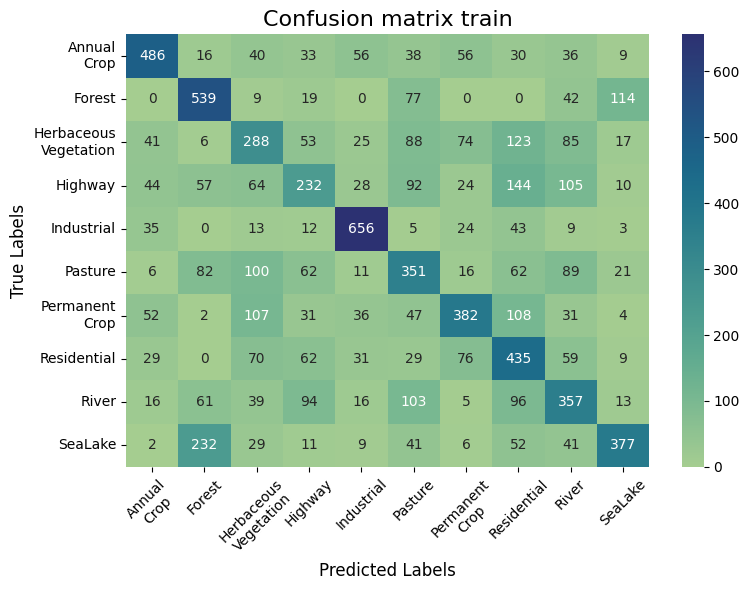

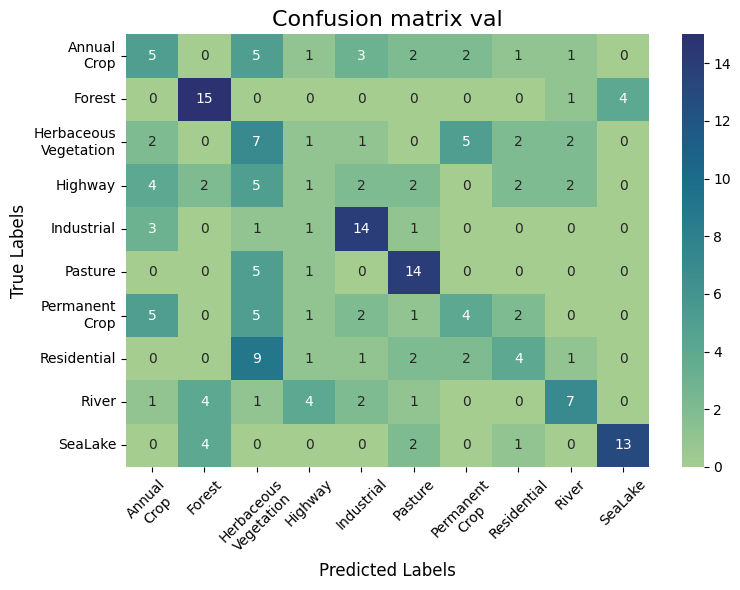

In [5]:
trainer.fit(model, train_loader, val_loader, 0.01)

## Choose params - HQNN Parallel